## Imports

In [56]:
%%time

# Data Manipulation
import pandas as pd
pd.set_option('use_inf_as_na', True)
import numpy as np
from sklearn.model_selection import train_test_split

# tweets processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

# Visual modules
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# Converting words to numbers (bags of words)
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Save model
import joblib

Wall time: 281 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bless\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
# Constants
TWITTER_LOGO = 'utils/Twitter logo 2012.png'
EXTRA_WORDS = 'utils/extra_words.txt'
TRAIN_FILE = r'Data/train.csv'
TEST_FILE = r'Data/test.csv'
FONT_PATH = r'gatsby\GatsbyFLF-bold.ttf'

In [58]:
#Load data and extract inputs and outputs
train_df = pd.read_csv(TRAIN_FILE).set_index('id')[:1000]

X = train_df.drop(['target'], axis = 1)
X = X.fillna(' ')
y = train_df.target

In [59]:
X.sample(frac=1).head()

,keyword,location,text
id,,,
144,accident,UK,.@NorwayMFA #Bahrain police had previously die...
68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
1190,blizzard,Sydney,@Ashayo @MsMiggi Hi Ashayo! I believe there wi...
997,blazing,Your screen,S3XLEAK!!!\nPh0tos of 19yrs old Ash@wo lady in...
82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'...


In [60]:
X['tweet'] = X.keyword + X.location + X.text
X.tweet[:3]

id
1      Our Deeds are the Reason of this #earthquake...
4               Forest fire near La Ronge Sask. Canada
5      All residents asked to 'shelter in place' ar...
Name: tweet, dtype: object

In [61]:
def process_tweet(tweet):
    extra_words = (pd.read_table(EXTRA_WORDS, header = None))[0].values.tolist()
    _stopwords = set(stopwords.words('english') + list(punctuation) +
                     ['AT_USER','URL'] + extra_words)
    
    tweet = tweet.lower() # convert tweets to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
    tweet =  re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet =  word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
    
    return [word for word in tweet if word not in _stopwords]

In [77]:
def process_tweets(tweets):
    tokened_text = tweets.apply(process_tweet)
    words = [word for item in tokened_text for word in item]
    cleaned_text_df = tokened_text.apply(' '.join)
    
    return words, cleaned_text_df

In [78]:
def make_cloud(word_tokens, image_file_path, font_path = None):
    
    """
    makes a word cloud from tokens, using the image in 
    image_file_path for a mask
    
    
    
    """
    
    word_str = ' '.join(word_tokens)
    
    mask = Image.open(image_file_path)
    img_mask = Image.new(mode='RGB', size=mask.size, color = (255,255,255))
    img_mask.paste(mask, box = mask)
    
    rgb_array = np.array(img_mask)
    

    cloud = WordCloud(font_path=font_path,
                  mask=rgb_array,background_color='black',
                  max_words=600, colormap = 'Set3')

    cloud.generate(word_str.upper())
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(cloud, interpolation='bilinear')

Wall time: 9.32 s


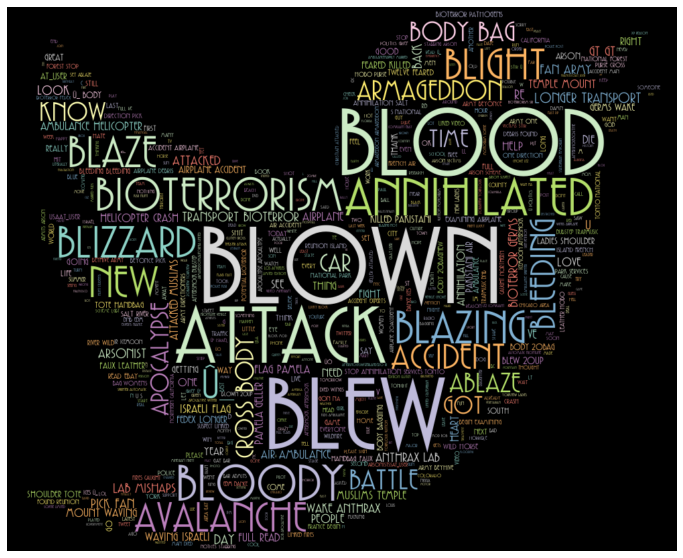

In [90]:
%%time
#Clean text and extract words
words, cleaned_tweets = process_tweets(X.tweet)

# Make wordcloud
make_cloud(words, TWITTER_LOGO, font_path=FONT_PATH)

In [91]:
def get_models():
    
    models = {'Gaussian NB': GaussianNB(),
              'SVC': LinearSVC(max_iter = 1000),
              'LR': LogisticRegression(C = 0.6),
              'RF': RandomForestClassifier(n_estimators = 200), 
              'SVC calibrated':CalibratedClassifierCV((LinearSVC(max_iter = 10000)), cv = 2, method = 'sigmoid'),
              'LR calibrated': CalibratedClassifierCV(LogisticRegression(), method = 'sigmoid',cv = 2)
             }
    
    return models

In [92]:
def scores_list_to_df(scores):
    """
    Takes a list and turns it into a sorted dataframe through a dict
    in an intermediate step.
    
    Args:
        scores: List of scores with models attributed to them

    Returns:
        A dataframe sorted by accuracy with 2 different bagging shemes
    
    """
    score_dict= dict((key,d[key]) for d in scores for key in d)
    score_df = pd.DataFrame.from_dict(score_dict,
                                      orient='index', columns=['vec_accuracy', 'tfid_accuracy', 'pca_accuracy'])
    
    return score_df.sort_values(by=['vec_accuracy', 'tfid_accuracy', 'pca_accuracy'], ascending = False)

Gaussian NB
Accuracy with vectorizer for Gaussian NB = 51.6%
Accuracy with tifd converter for Gaussian NB = 52.5%
Accuracy with pca for Gaussian NB = 43.4%


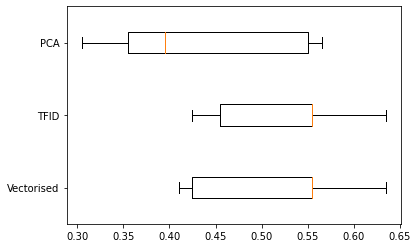




SVC
Accuracy with vectorizer for SVC = 52.9%
Accuracy with tifd converter for SVC = 54.1%
Accuracy with pca for SVC = 61.4%


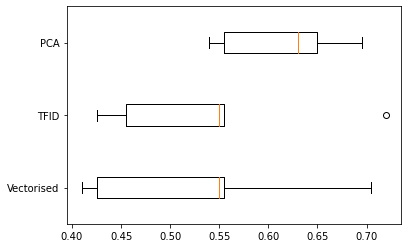




LR
Accuracy with vectorizer for LR = 52.1%
Accuracy with tifd converter for LR = 59.6%
Accuracy with pca for LR = 62.5%


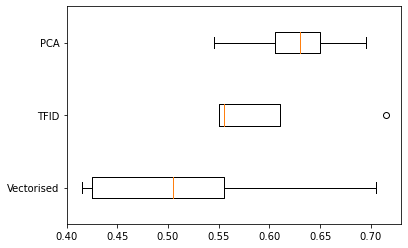




RF
Accuracy with vectorizer for RF = 52.9%
Accuracy with tifd converter for RF = 53.2%
Accuracy with pca for RF = 50.7%


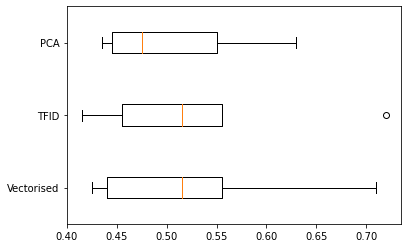




SVC calibrated
Accuracy with vectorizer for SVC calibrated = 68.1%
Accuracy with tifd converter for SVC calibrated = 69.9%
Accuracy with pca for SVC calibrated = 63.8%


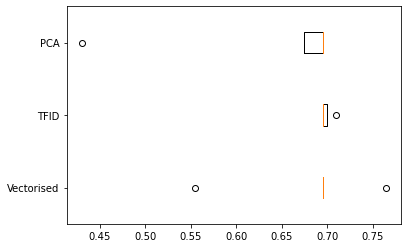




LR calibrated
Accuracy with vectorizer for LR calibrated = 72.6%
Accuracy with tifd converter for LR calibrated = 70.6%
Accuracy with pca for LR calibrated = 66.4%


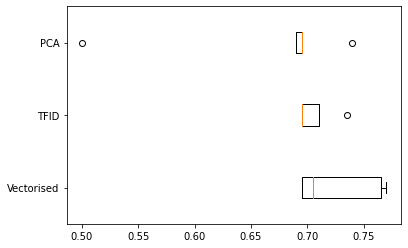




Wall time: 9.13 s


In [93]:
%%time

models = get_models()

vectorizer = CountVectorizer(max_features = 20, min_df = 5, max_df = 0.7)
train_array = vectorizer.fit_transform(cleaned_tweets).toarray()

converter = TfidfTransformer()
Tfid_train_array = converter.fit_transform(train_array).toarray()

pca = PCA(n_components = 10, svd_solver='full')
pca_train_array = pca.fit_transform(train_array)

cv_scores = []

scores = []
for model in models:
    clf = models[model]
    
    vec_scores = cross_val_score(clf,train_array, y, cv = 5)
    mean_vec_score = np.mean(vec_scores)
    
    tfid_scores = cross_val_score(clf, Tfid_train_array, y, cv = 5)
    mean_tfid_score = np.mean(tfid_scores)
    
    pca_scores = cross_val_score(clf, pca_train_array, y, cv = 5)
    mean_pca_score = np.mean(pca_scores) 
    
    print(model)
    print(f"Accuracy with vectorizer for {model} = {mean_vec_score:.1%}")
    print(f"Accuracy with tifd converter for {model} = {mean_tfid_score:.1%}")
    print(f"Accuracy with pca for {model} = {mean_pca_score:.1%}")
    
    _ = plt.boxplot([vec_scores, tfid_scores, pca_scores], vert=False)
    plt.yticks([1,2,3], ['Vectorised', 'TFID', 'PCA'])
    plt.show()
    print("\n"*2)
    
    score = {model:[mean_vec_score, mean_tfid_score, mean_pca_score]}
    scores.append(score)

In [94]:
model_scores_df = scores_list_to_df(scores)
model_scores_df

,vec_accuracy,tfid_accuracy,pca_accuracy
LR calibrated,0.726,0.706,0.664
SVC calibrated,0.681,0.699,0.638
SVC,0.529,0.541,0.614
RF,0.529,0.532,0.507
LR,0.521,0.596,0.625
Gaussian NB,0.516,0.525,0.434


In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


pipe = Pipeline([('vec', vec),('TFID', TfidfTransformer()), ('LR Calibrated',models['LR calibrated'])])

TypeError: fit_transform() missing 1 required positional argument: 'raw_documents'

In [103]:
vec = Pipeline([('vec',vectorizer)])

In [158]:
i = vectorizer.fit(cleaned_tweets,y)

numpy.int64

TypeError: 'CountVectorizer' object is not callable

In [145]:
def real_pipeline(cleaned_docs, y, max_features = 20, min_df = 5):
    w = CountVectorizer(max_features = max_features, min_df = min_df, max_df = 0.7).fit_transform(cleaned_docs).toarray()
    e = TfidfTransformer().fit_transform(w)
    r = models['LR calibrated'].fit(e, y)
    return r

In [146]:
f = FunctionTransformer(real_pipeline)

In [147]:
p = Pipeline([('f',f)])

In [148]:
p.get_params()

{'memory': None,
 'steps': [('f',
   FunctionTransformer(func=<function real_pipeline at 0x000001D841D1EC18>))],
 'verbose': False,
 'f': FunctionTransformer(func=<function real_pipeline at 0x000001D841D1EC18>),
 'f__accept_sparse': False,
 'f__check_inverse': True,
 'f__func': <function __main__.real_pipeline(cleaned_docs, y, max_features=20, min_df=5)>,
 'f__inv_kw_args': None,
 'f__inverse_func': None,
 'f__kw_args': None,
 'f__validate': False}

In [149]:
pipe.get_params()

{'memory': None,
 'steps': [('vec',
   FunctionTransformer(func=CountVectorizer(max_df=0.7, max_features=20, min_df=5))),
  ('TFID', TfidfTransformer()),
  ('LR Calibrated',
   CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=2))],
 'verbose': False,
 'vec': FunctionTransformer(func=CountVectorizer(max_df=0.7, max_features=20, min_df=5)),
 'TFID': TfidfTransformer(),
 'LR Calibrated': CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=2),
 'vec__accept_sparse': False,
 'vec__check_inverse': True,
 'vec__func__analyzer': 'word',
 'vec__func__binary': False,
 'vec__func__decode_error': 'strict',
 'vec__func__dtype': numpy.int64,
 'vec__func__encoding': 'utf-8',
 'vec__func__input': 'content',
 'vec__func__lowercase': True,
 'vec__func__max_df': 0.7,
 'vec__func__max_features': 20,
 'vec__func__min_df': 5,
 'vec__func__ngram_range': (1, 1),
 'vec__func__preprocessor': None,
 'vec__func__stop_words': None,
 'vec__func__strip_accents': None,
 'vec__func__token_patt

In [151]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline



pipe = Pipeline([('vec', CountVectorizer()),('TFID', TfidfTransformer()), ('LR Calibrated',models['LR calibrated'])])

parameters = {'vec__max_features':[np.linspace(10,50,10)],
              'TFID__norm': ['l1', 'l2'],
              'TFID__sublinear_tf': [False,True],
              'LR Calibrated__base_estimator__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'LR Calibrated__base_estimator__C':np.linspace(0.01,0.08,20),
              'LR Calibrated__base_estimator__warm_start': [True, False],
              'LR Calibrated__base_estimator__max_iter':[500]
             }

clf = GridSearchCV(pipe, parameters, verbose=0)
clf.fit(cleaned_tweets, y)

C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, 

ValueError: max_features=array([10.        , 14.44444444, 18.88888889, 23.33333333, 27.77777778,
       32.22222222, 36.66666667, 41.11111111, 45.55555556, 50.        ]), neither a positive integer nor None

In [154]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline



pipe = Pipeline([('vec', CountVectorizer()), ('LR Calibrated',models['LR calibrated'])])

parameters = {'vec__max_features':[np.linspace(10,50,10)],
              'LR Calibrated__base_estimator__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'LR Calibrated__base_estimator__C':np.linspace(0.01,0.08,20),
              'LR Calibrated__base_estimator__warm_start': [True, False],
              'LR Calibrated__base_estimator__max_iter':[500]
             }

clf = GridSearchCV(pipe, parameters, verbose=0)
clf.fit(cleaned_tweets, y)

C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\bless\Anaconda3\envs\tf\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, 

ValueError: max_features=array([10.        , 14.44444444, 18.88888889, 23.33333333, 27.77777778,
       32.22222222, 36.66666667, 41.11111111, 45.55555556, 50.        ]), neither a positive integer nor None

In [152]:
print(clf.best_score_)
print(clf.best_params_)

nan
{'LR Calibrated__base_estimator__C': 0.01, 'LR Calibrated__base_estimator__max_iter': 500, 'LR Calibrated__base_estimator__solver': 'newton-cg', 'LR Calibrated__base_estimator__warm_start': True, 'TFID__norm': 'l1', 'TFID__sublinear_tf': False, 'vec__max_features': array([10.        , 14.44444444, 18.88888889, 23.33333333, 27.77777778,
       32.22222222, 36.66666667, 41.11111111, 45.55555556, 50.        ])}


In [37]:
filename = 'finalized_model.sav'
joblib.dump(clf.best_estimator_, filename)

['finalized_model.sav']

In [74]:
pipe.get_params()

{'memory': None,
 'steps': [('TFID', TfidfTransformer()),
  ('LR Calibrated',
   CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=2))],
 'verbose': False,
 'TFID': TfidfTransformer(),
 'LR Calibrated': CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=2),
 'TFID__norm': 'l2',
 'TFID__smooth_idf': True,
 'TFID__sublinear_tf': False,
 'TFID__use_idf': True,
 'LR Calibrated__base_estimator__C': 1.0,
 'LR Calibrated__base_estimator__class_weight': None,
 'LR Calibrated__base_estimator__dual': False,
 'LR Calibrated__base_estimator__fit_intercept': True,
 'LR Calibrated__base_estimator__intercept_scaling': 1,
 'LR Calibrated__base_estimator__l1_ratio': None,
 'LR Calibrated__base_estimator__max_iter': 100,
 'LR Calibrated__base_estimator__multi_class': 'auto',
 'LR Calibrated__base_estimator__n_jobs': None,
 'LR Calibrated__base_estimator__penalty': 'l2',
 'LR Calibrated__base_estimator__random_state': None,
 'LR Calibrated__base_estimator__solver': 'lbfgs',
 'LR 

# Generate predictions

In [19]:
test_df = pd.read_csv(TEST_FILE).set_index('id')

In [20]:
X_test = test_df.keyword.fillna(' ')+' '+test_df.location.fillna(' ') +' '+test_df.text.fillna(' ')

Wall time: 19.1 s


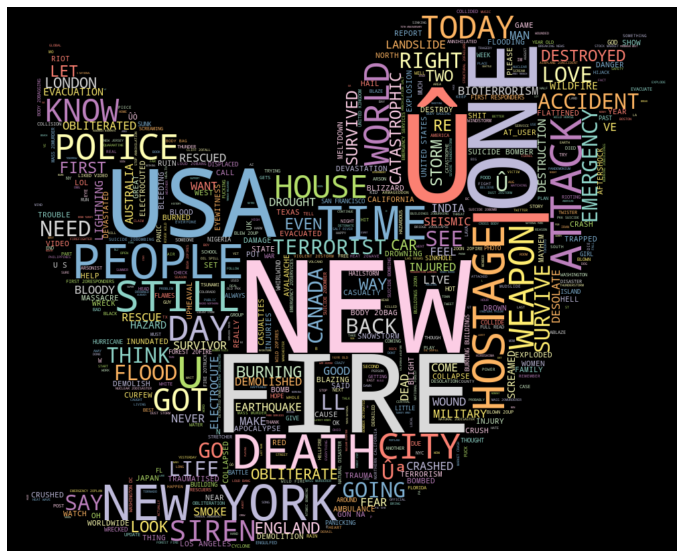

In [21]:
%%time
#Clean text and extract words
test_words, test_array = process_tweets(X_test)

#Make wordcloud
make_cloud(test_words, TWITTER_LOGO)

In [22]:
loaded_model = joblib.load(filename)

In [23]:
test_array.shape

(3263, 100)

In [24]:
results = loaded_model.predict(test_array)

In [ ]:
df = pd.DataFrame(data=results, index=range(len(results)), columns=test_df.id, )